V0 Семантическая сегментация. Самая простая.

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Используемое устройство: cuda
Загрузка модели SAM...
SAM готов.
Загрузка модели CLIP...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


CLIP готов.

--- Обработка изображения: 1_normals.jpg ---
Изображение загружено, запускаю сегментацию...
Сегментация завершена. Найдено 35 масок.

Запускаю классификацию масок с помощью CLIP...
  Маска 1/35: снег (уверенность: 0.55)
  Маска 2/35: снег (уверенность: 0.58)
  Маска 3/35: снег (уверенность: 0.45)
  Маска 4/35: человек в желтой куртке (уверенность: 0.48)
  Маска 5/35: снег (уверенность: 0.34)
  Маска 6/35: снег (уверенность: 0.73)
  Маска 7/35: снег (уверенность: 0.58)
  Маска 8/35: дерево (уверенность: 0.49)
  Маска 9/35: человек в желтой куртке (уверенность: 0.32)
  Маска 10/35: дерево (уверенность: 0.39)
  Маска 11/35: небо (уверенность: 0.79)
  Маска 12/35: дерево (уверенность: 0.39)
  Маска 13/35: человек в желтой куртке (уверенность: 0.89)
  Маска 14/35: снег (уверенность: 0.36)
  Маска 15/35: небо (уверенность: 0.39)
  Маска 16/35: небо (уверенность: 0.45)
  Маска 17/35: небо (уверенность: 0.49)
  Маска 18/35: небо (уверенность: 0.57)
  Маска 19/35: человек в желтой 

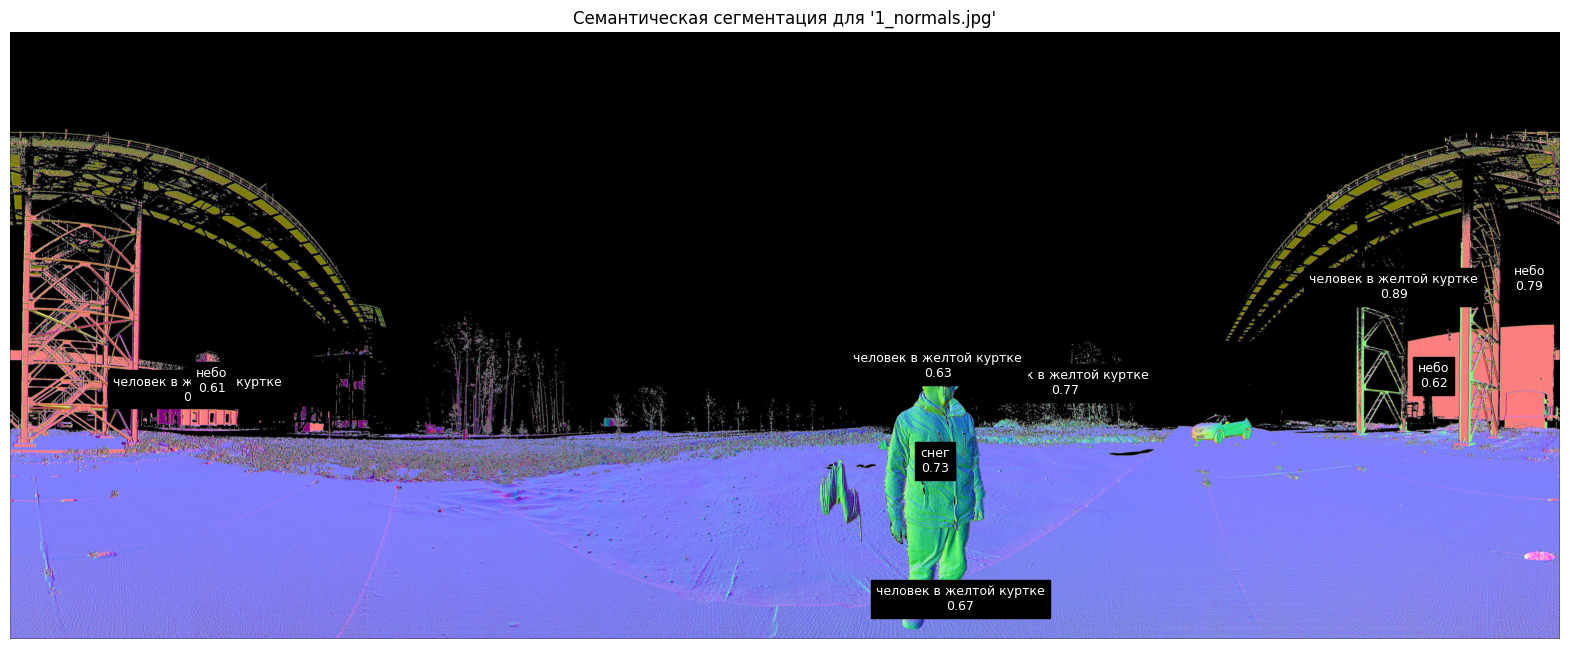

In [1]:
# === Шаг 1: Импорт всех библиотек ===
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os

# === Шаг 2: Настройка окружения и загрузка моделей ===

# --- Настройка устройства ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device}")

# --- Загрузка Segment Anything Model (SAM) ---
print("Загрузка модели SAM...")
sam_checkpoint = "/app/MODELS/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
print("SAM готов.")

# --- Загрузка CLIP ---
print("Загрузка модели CLIP...")
# 'openai/clip-vit-large-patch14' - одна из самых мощных моделей CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
print("CLIP готов.")


# === Шаг 3: Сегментация и Классификация ===

# --- Определяем путь к изображению и классы для семантики ---
image_path = "/app/CODE/Vistino20241014_E57/1_normals.jpg"
image_name = os.path.basename(image_path)
# *** ВАЖНО: Определите свои классы, которые вы ожидаете увидеть на фото ***
semantic_labels = ["человек в желтой куртке", "арка моста", "опора моста", "дерево", "снег", "небо"]

# --- Загружаем и сегментируем изображение ---
print(f"\n--- Обработка изображения: {image_name} ---")
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    print(f"Ошибка: не удалось загрузить изображение по пути {image_path}")
else:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print("Изображение загружено, запускаю сегментацию...")
    masks = mask_generator.generate(image_rgb)
    print(f"Сегментация завершена. Найдено {len(masks)} масок.")

    # --- Классифицируем каждую маску ---
    semantic_results = []
    print("\nЗапускаю классификацию масок с помощью CLIP...")
    for i, mask_data in enumerate(masks):
        # Вырезаем область изображения по рамке (bbox)
        x, y, w, h = mask_data['bbox']
        cropped_image = image_rgb[y:y+h, x:x+w]
        
        # Конвертируем в PIL Image, т.к. CLIP работает с ним
        pil_image = Image.fromarray(cropped_image)
        
        # Готовим данные для CLIP
        inputs = clip_processor(text=semantic_labels, images=pil_image, return_tensors="pt", padding=True).to(device)
        
        # Получаем предсказания
        with torch.no_grad():
            outputs = clip_model(**inputs)
        
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        best_label_index = probs.argmax()
        
        # Сохраняем результат
        mask_data['label'] = semantic_labels[best_label_index]
        mask_data['confidence'] = probs.max().item()
        semantic_results.append(mask_data)
        
        # Печатаем прогресс для наглядности
        print(f"  Маска {i+1}/{len(masks)}: {mask_data['label']} (уверенность: {mask_data['confidence']:.2f})")

    print("Классификация завершена.")


# === Шаг 4: Визуализация с семантикой ===

def visualize_semantic_masks(image_rgb, results):
    plt.figure(figsize=(20, 15))
    plt.imshow(image_rgb)
    
    # Сортируем маски, чтобы сначала рисовались самые большие
    sorted_results = sorted(results, key=(lambda x: x['area']), reverse=True)
    
    for res in sorted_results:
        mask = res['segmentation']
        label = res['label']
        confidence = res['confidence']
        
        # Создаем цветную маску
        color = np.random.random(3)
        mask_image = np.zeros_like(image_rgb)
        mask_image[mask] = (color * 255).astype(np.uint8)
        
        # Накладываем маску с прозрачностью
        blended = cv2.addWeighted(plt.gca().get_images()[0].get_array().astype(np.uint8), 1.0, mask_image, 0.5, 0)
        plt.imshow(blended)
        
        # Добавляем текст с меткой
        # Находим центр маски для размещения текста
        x, y, w, h = res['bbox']
        center_x, center_y = x + w // 2, y + h // 2
        
        # Пишем текст, только если уверенность высокая
        if confidence > 0.6: # Порог уверенности, можно менять
            plt.text(center_x, center_y, f"{label}\n{confidence:.2f}", 
                     color='white', backgroundcolor='black',
                     fontsize=9, ha='center', va='center')
            
    plt.axis('off')
    plt.title(f"Семантическая сегментация для '{image_name}'")
    plt.show()

# Запускаем визуализацию, если есть результаты
if 'semantic_results' in locals() and semantic_results:
    visualize_semantic_masks(image_rgb, semantic_results)